In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import xgboost as xgb

from scipy.stats import uniform, randint
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [2]:
df = pd.read_csv('train.csv', index_col='id')
df

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
id,,,,,,,,,
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8
...,...,...,...,...,...,...,...,...,...
74046,F,1.6625,1.2625,0.4375,50.660556,20.680960,10.361742,12.332033,10
74047,I,1.0750,0.8625,0.2750,10.446791,4.323299,2.296310,3.543687,6
74048,F,1.4875,1.2000,0.4125,29.483480,12.303683,7.540967,8.079607,10


In [3]:
#outliers handling
# outliers change
def trimming_outlier(data=df,kolom_data=df.select_dtypes(include='number').columns[:-1]):
    for sex in data.Sex.unique():
        data_sex = data[data['Sex'] == sex]
        for kolom in kolom_data:
            # hitung nilai interquartile upper bound dan lower bound
            q1 = np.quantile(data_sex.loc[:,kolom],0.25)
            q3 = np.quantile(data_sex.loc[:,kolom],0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5*iqr
            upper_bound = q3 + 1.5*iqr
            data_sex[kolom] = np.where(data_sex[kolom] > upper_bound, upper_bound,
                                        np.where(data_sex[kolom] < lower_bound,lower_bound,data_sex[kolom]))
        data[data['Sex'] == sex] = data_sex
    
    return data

In [4]:
df = trimming_outlier()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_1568\1139437668.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sex[kolom] = np.where(data_sex[kolom] > upper_bound, upper_bound,


In [5]:
X = df.drop('Age', axis=1)
y = df['Age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55538, 8), (18513, 8), (55538,), (18513,))

In [6]:
# weight feature
def get_neto_weight(df):
    df['neto_weight'] = df['Shell Weight'] + df['Shucked Weight'] + df['Viscera Weight']
    return df

def get_res_weight(df):
    df['res_weight'] = df['Weight'] - (df['Shell Weight'] + df['Shucked Weight'] + df['Viscera Weight'])
    return df

#Ratio Feature
def get_viscera_ratio(df):
    df['viscera_ratio'] = df['Viscera Weight'] / df['Weight']
    return df

def get_shell_ratio(df):
    df['shell_ratio'] = df['Shell Weight'] / df['Weight']
    return df

def get_shell_body_ratio(df):
    df['shell_body_ratio'] = df['Shell Weight'] / (df['Weight'] + df['Shell Weight'])
    return df

def get_meat_yield(df):
    df['meat_yield'] = df['Shucked Weight'] / (df['Weight'] + df['Shell Weight'])
    return df

def get_length_diameter_ratio(df):
    df['length_diameter_ratio'] = df['Length'] / df['Diameter']
    return df

def get_weight_viscera_ratio(df):
    df['weight_viscera_ratio'] = df['Weight'] / df['Viscera Weight']
    return df

def get_weight_shell_ratio(df):
    df['weight_shell_ratio'] = df['Weight'] / df['Shell Weight']
    return df

def get_weight_shucked_ratio(df):
    df['weight_shucked_ratio'] = df['Weight'] / df['Shucked Weight']
    return df

#Geometric Features
def get_surface_area(df):
    df['surface_area'] = 2 * (df['Length'] * df['Diameter'] + df['Length'] * df['Height'] + df['Diameter'] * df['Height'])
    return df

def get_volume(df):
    df['volume'] = df['Length'] * df['Diameter'] * df['Height']
    return df

def get_density(df):
    df['density'] = df['Weight'] / (df['Length'] * df['Diameter'] * df['Height'])
    return df

def get_pseudo_bmi(df):
    df['pseudo_bmi'] = df['Weight'] / (df['Height']**2)
    return df

def get_body_condition_index(df):
    df['body_condition_index'] = np.sqrt(df['Length'] * df['Weight'] * df['Shucked Weight'])
    return df


# unknown sex feature
def get_unk_sex(df):
    df['sex_l'] = df['Sex'].map(lambda x: 1 if x == 'I' else 0)
    return df[['sex_l']]


In [7]:
feature_engineering_num = ColumnTransformer([
    ('neto_weight', FunctionTransformer(get_neto_weight, validate=False),
     ['Shell Weight', 'Shucked Weight', 'Viscera Weight']),
    ('res_weight', FunctionTransformer(get_res_weight, validate=False),
     ['Weight','Shell Weight', 'Shucked Weight', 'Viscera Weight']),
    ('viscera_ratio', FunctionTransformer(get_viscera_ratio, validate=False),
     ['Viscera Weight', 'Weight']),
    ('shell_ratio', FunctionTransformer(get_shell_ratio, validate=False),
     ['Shell Weight', 'Weight']),
    ('shell_body_ratio', FunctionTransformer(get_shell_body_ratio, validate=False),
     ['Shell Weight', 'Weight']),
    ('meat_yield', FunctionTransformer(get_meat_yield, validate=False),
     ['Shucked Weight', 'Weight', 'Shell Weight']),
    ('length_diameter_ratio', FunctionTransformer(get_length_diameter_ratio, validate=False),
     ['Length', 'Diameter']),
    ('weight_viscera_ratio', FunctionTransformer(get_weight_viscera_ratio, validate=False),
     ['Weight', 'Viscera Weight']),
    ('weight_shell_ratio', FunctionTransformer(get_weight_shell_ratio, validate=False),
     ['Weight', 'Shell Weight']),
    ('weight_shucked_ratio', FunctionTransformer(get_weight_shucked_ratio, validate=False),
     ['Weight', 'Shucked Weight']),
    ('surface_area', FunctionTransformer(get_surface_area, validate=False),
     ['Length', 'Diameter', 'Height']),
    ('volume', FunctionTransformer(get_volume, validate=False),
    ['Length', 'Diameter', 'Height']),
    ('density', FunctionTransformer(get_density, validate=False),
     ['Weight', 'Length', 'Diameter', 'Height']),
    ('pseudo_bmi', FunctionTransformer(get_pseudo_bmi, validate=False),
     ['Weight', 'Height']),
    ('body_condition_index', FunctionTransformer(get_body_condition_index, validate=False),
     ['Length', 'Weight', 'Shucked Weight'])
])

In [23]:
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train.select_dtypes(include='object').columns.tolist()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True))
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat',cat_pipeline, cat_cols),
    ('feature_engineering_num', feature_engineering_num, num_cols)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('algo', lgb.LGBMRegressor(random_state=42))
])

In [24]:
params = {
    'algo__num_leaves': Integer(50, 100),
    'algo__max_depth': Integer(5, 10),
    'algo__learning_rate': Real(0.001, 0.1),
    'algo__max_bin': Integer(20, 100),
    'algo__min_data_in_leaf': Integer(100, 500),
    'algo__num_iterations': Integer(100, 500),
    'algo__min_sum_hessian_in_leaf': Integer(20,60),
    'algo__feature_fraction': Real(0.1, 0.6),
    'algo__subsample': Real(0.1, 0.9),
    'algo__bagging_fraction': Real(0.5, 0.9),
    'algo__lambda_l1': Real(0.0001, 0.1),
    'algo__lambda_l2': Real(0.0001, 0.1)
}

model = BayesSearchCV(pipeline, params, cv=3, n_iter=25, n_jobs=-1, verbose=1, random_state=42, scoring='neg_mean_absolute_error')
model.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

c:\Users\ASUS\anaconda3\envs\datascience\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.2778665685361621, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2778665685361621
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=20, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.8213338634012417, subsample=0.4329729178438002 will be ignored. Current value: bagging_fraction=0.8213338634012417
[LightGBM] [Warning] lambda_l1 is set=0.05504693096834447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05504693096834447
[LightGBM] [Warning] lambda_l2 is set=0.002709976794613226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002709976794613226


BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('scaler',
                                                                                           MinMaxScaler()),
                                                                                          ('poly',
                                                                                           PolynomialFeatures(interaction_only=True))]),
                                                                          ['Length',
                                                                           'Diameter',
                                                                           'Height',
                                                                           'Weight',
                                                                           'Shucked '
                                                                           'Weight',
                                                                           'Viscera '
                                                                           'Weight',
                                                                           'Shell '
                                                                           'Weight']),
                                                                         ('cat',
                                                                          Pipeline(s...
                             'algo__min_sum_hessian_in_leaf': Integer(low=20, high=60, prior='uniform', transform='normalize'),
                             'algo__num_iterations': Integer(low=100, high=500, prior='uniform', transform='normalize'),
                             'algo__num_leaves': Integer(low=50, high=100, prior='uniform', transform='normalize'),
                             'algo__subsample': Real(low=0.1, high=0.9, prior='uniform', transform='normalize')},
              verbose=1)

In [25]:
model.best_params_, model.best_score_, model.score(X_train, y_train), model.score(X_test, y_test)

(OrderedDict([('algo__bagging_fraction', 0.8213338634012417),
              ('algo__feature_fraction', 0.2778665685361621),
              ('algo__lambda_l1', 0.05504693096834447),
              ('algo__lambda_l2', 0.002709976794613226),
              ('algo__learning_rate', 0.04651948894038998),
              ('algo__max_bin', 65),
              ('algo__max_depth', 5),
              ('algo__min_data_in_leaf', 100),
              ('algo__min_sum_hessian_in_leaf', 20),
              ('algo__num_iterations', 117),
              ('algo__num_leaves', 76),
              ('algo__subsample', 0.4329729178438002)]),
 -1.406978461231299,
 -1.3832273641087722,
 -1.411253998013093)

In [26]:
model.best_estimator_.named_steps['algo'].feature_importances_

array([  0,  50,  38,  91,  53,  75,  33, 150,  30,  43,  22,  35,  16,
        31,  29,  20,  28,  14,  28,  47,  20,  28,  85,  16,  23,  40,
        37,  14,  12,  29,  31,  26,  73,  44,  19,  26,  26,  69,  50,
         9,  95,   4,  19,  88,  38,  10,  90,  40,  10,  50,  16,   5,
        24, 215,  34,  25,  77,   4,  12,  47,   0,  15,  63,   2,   2,
       167,  19,  33,  60,  18,  21,  11,  65,  35,   1,  11,   5,  30,
        58,   1,  21,  74,  12,   0,  11,  12])

In [27]:
model.best_estimator_.named_steps['preprocessor']

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler()),
                                                 ('poly',
                                                  PolynomialFeatures(interaction_only=True))]),
                                 ['Length', 'Diameter', 'Height', 'Weight',
                                  'Shucked Weight', 'Viscera Weight',
                                  'Shell Weight']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot'...
                                                                   'Height']),
                                                                 ('pseudo_bmi',
                                                                  FunctionTransformer(func=<function get_pseudo_bmi at 0x0000019B8BA5F380>),
                                                                  ['Weight',
                                                                   'Height']),
                                                                 ('body_condition_index',
                                                                  FunctionTransformer(func=<function get_body_condition_index at 0x0000019B8BA5F420>),
                                                                  ['Length',
                                                                   'Weight',
                                                                   'Shucked '
                                                                   'Weight'])]),
                                 ['Length', 'Diameter', 'Height', 'Weight',
                                  'Shucked Weight', 'Viscera Weight',
                                  'Shell Weight'])])

In [28]:
test = pd.read_csv('test.csv', index_col='id')
submid = pd.read_csv('sample_submission.csv', index_col='id')

In [29]:
submid['Age'] = model.predict(test).round().astype(int)

In [30]:
model.predict(test)

array([ 7.57782339,  7.7975831 , 10.76939839, ..., 13.39192925,
       10.01634799, 11.79947609])

In [31]:
submid.to_csv('submission82.csv')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74051 entries, 0 to 74050
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             74051 non-null  object 
 1   Length          74051 non-null  float64
 2   Diameter        74051 non-null  float64
 3   Height          74051 non-null  float64
 4   Weight          74051 non-null  float64
 5   Shucked Weight  74051 non-null  float64
 6   Viscera Weight  74051 non-null  float64
 7   Shell Weight    74051 non-null  float64
 8   Age             74051 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 5.6+ MB


In [33]:
df.drop('Sex', axis=1).corr()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
Length,1.000000,0.989284,0.928895,0.939208,0.920239,0.920248,0.924072,0.613481
Diameter,0.989284,1.000000,0.931616,0.940908,0.918766,0.920570,0.929577,0.621783
Height,0.928895,0.931616,1.000000,0.915318,0.878688,0.896367,0.920235,0.646366
Weight,0.939208,0.940908,0.915318,1.000000,0.972596,0.972370,0.969233,0.603657
Shucked Weight,0.920239,0.918766,0.878688,0.972596,1.000000,0.945312,0.918250,0.507891
Viscera Weight,0.920248,0.920570,0.896367,0.972370,0.945312,1.000000,0.939231,0.578720
Shell Weight,0.924072,0.929577,0.920235,0.969233,0.918250,0.939231,1.000000,0.664947
Age,0.613481,0.621783,0.646366,0.603657,0.507891,0.578720,0.664947,1.000000


<Axes: >

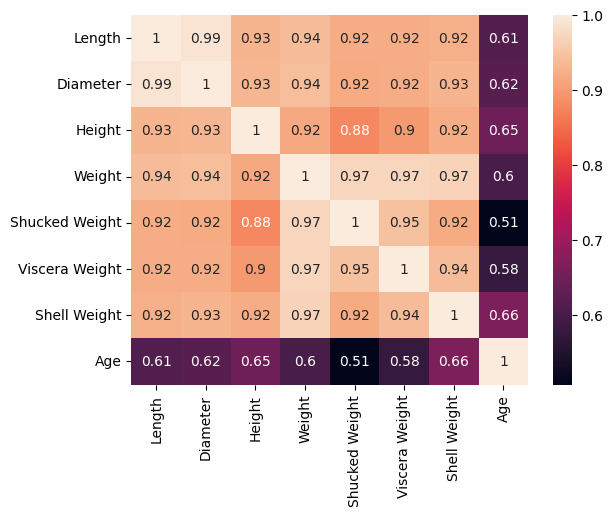

In [34]:
sns.heatmap(df.drop('Sex', axis=1).corr(), annot=True)

In [35]:
df.groupby('Sex').mean()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
Sex,,,,,,,,
F,1.467908,1.149528,0.395154,29.854060,12.762451,6.489615,8.553230,11.341547
I,1.046371,0.798858,0.263265,11.590423,5.108259,2.474827,3.398124,7.599073
M,1.437509,1.124814,0.383731,28.159039,12.175758,6.095817,8.037333,10.895953


<Axes: xlabel='Shucked Weight', ylabel='Age'>

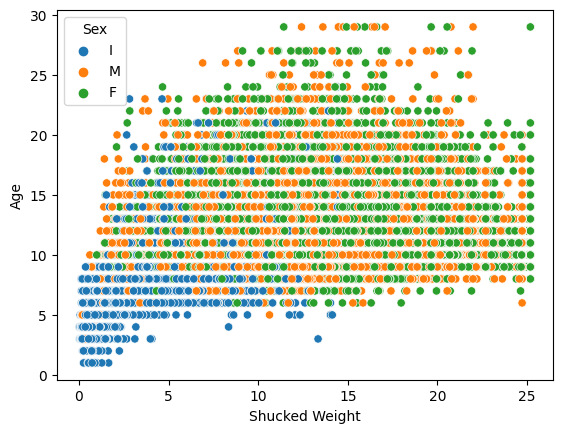

In [36]:
sns.scatterplot(data=df, x='Shucked Weight', y='Age', hue='Sex')